### Here, we will begin to drop some features, perform some data imputation (as proposed in the paper).

Just some notes:

In the paper, the authors replace the missing values with the column's mean.

Since most of the missing values are from columns that are integer values / discrete, we will replace them with the most frequent instead.

We will then implement the outlier equation used in the paper.

In [2]:
import pandas as pd
import numpy as np
X_train = pd.read_csv("X_train", delimiter = ",")
X_test = pd.read_csv("X_test", delimiter = ",")
t_train = pd.read_csv("t_train", delimiter = ",")
t_test = pd.read_csv("t_test",  delimiter = ",")

In [4]:
### Let's look at the class distribution
t_train.value_counts()

readmitted
0             49431
1             42158
dtype: int64

In [5]:
t_test.value_counts()

readmitted
0             5433
1             4744
dtype: int64

In [20]:
X_train.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

In [21]:
len(X_train['encounter_id'].unique())

91589

In [22]:
len(X_train)

91589

### It seems that encounter id is just a number assigned to each observation. Let's remove it as it is just an extra column to worry about. Additionally, let's remove the payer_code as it really doesn't matter what type of card they pay with...

In [23]:
X_train = X_train.drop(columns = ["encounter_id","payer_code"])
X_test = X_test.drop(columns = ["encounter_id","payer_code"])

In [24]:
t_train['readmitted'].unique()

array([1, 0], dtype=int64)

### Imputation.

The paper proposes the following for filling in missing values:

1. Missing data will be replaced by the median.
2. Use the equation: outlier > mean + |3 * s| where s is the standard deviation of the column.

Essentially, an outlier is 3 standard deviations from the mean

Before we do that, let's look at the distribution using bar plots for missing values

In [28]:
### Checking Missing Values:
for i in X_train.columns:
    print(str(i) + ":::" + str(X_train[i].isna().sum()))

patient_nbr:::0
race:::2053
gender:::0
age:::0
weight:::88689
admission_type_id:::0
discharge_disposition_id:::0
admission_source_id:::0
time_in_hospital:::0
medical_specialty:::44854
num_lab_procedures:::0
num_procedures:::0
num_medications:::0
number_outpatient:::0
number_emergency:::0
number_inpatient:::0
diag_1:::16
diag_2:::324
diag_3:::1272
number_diagnoses:::0
max_glu_serum:::0
A1Cresult:::0
metformin:::0
repaglinide:::0
nateglinide:::0
chlorpropamide:::0
glimepiride:::0
acetohexamide:::0
glipizide:::0
glyburide:::0
tolbutamide:::0
pioglitazone:::0
rosiglitazone:::0
acarbose:::0
miglitol:::0
troglitazone:::0
tolazamide:::0
examide:::0
citoglipton:::0
insulin:::0
glyburide-metformin:::0
glipizide-metformin:::0
glimepiride-pioglitazone:::0
metformin-rosiglitazone:::0
metformin-pioglitazone:::0
change:::0
diabetesMed:::0


## Important note:

A lot of the data that is missing comes from categorical, labeled data.

I.e, diagnosis 1, 2, and 3, medical specialty, weight, and race were all variables that we analyzed as being continuous. Thus, we will replace missing values with the mode.

In [29]:
missing_cols = ["diag_1","diag_2","diag_3", "medical_specialty", "weight", "race"]

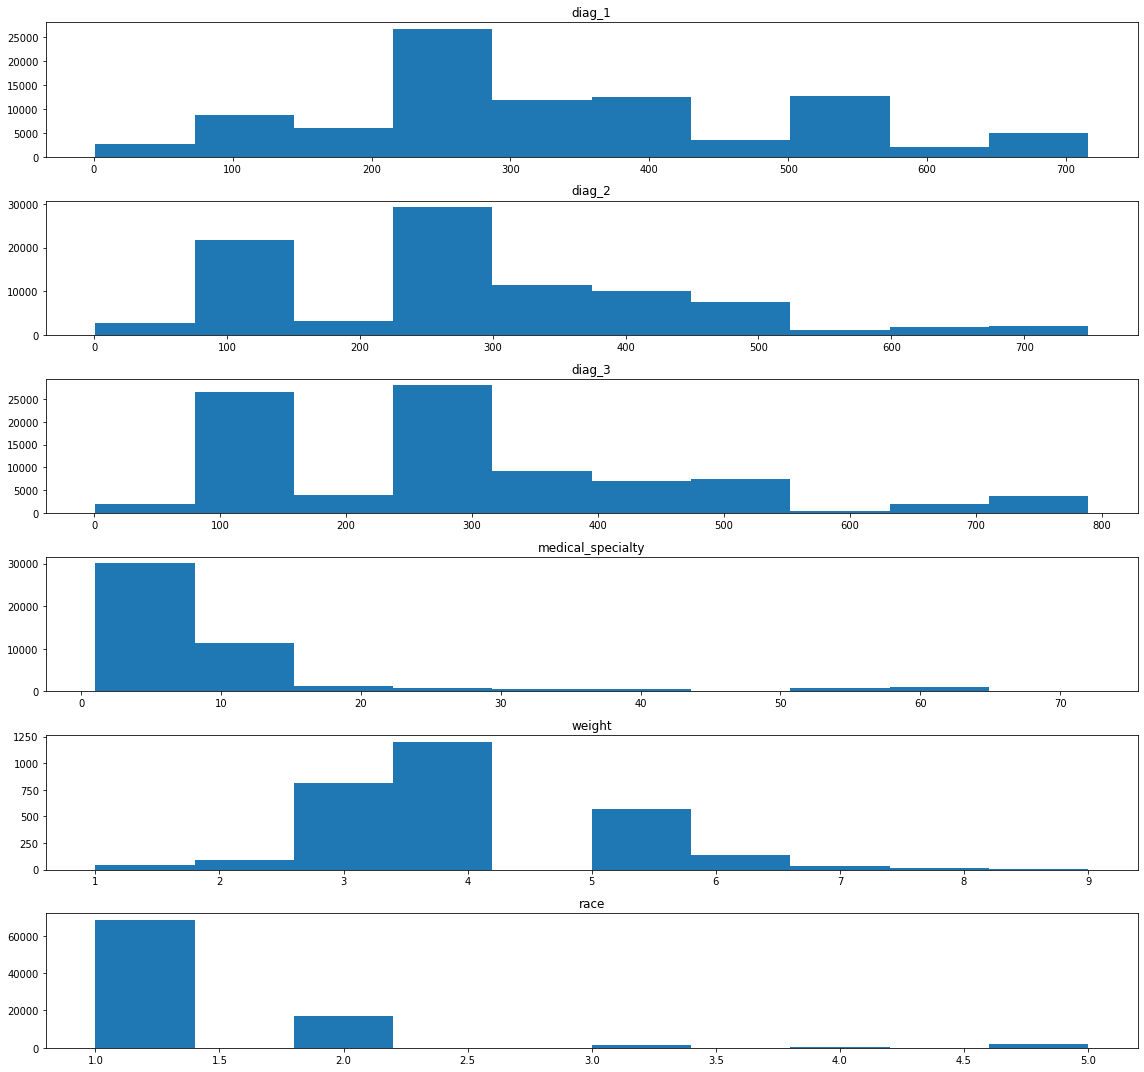

In [30]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(missing_cols), figsize = (16,15), tight_layout = True)
k = 0
for i in range(len(missing_cols)):
    axes[i].hist(X_train[missing_cols[k]])
    axes[i].title.set_text(missing_cols[k])
    k += 1

In [31]:
## Lets replace missing values with mode for all out columns
from sklearn.impute import SimpleImputer
names = X_train.columns
imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)
X_train = pd.DataFrame(X_train, columns = names)
X_test = pd.DataFrame(X_test, columns = names)

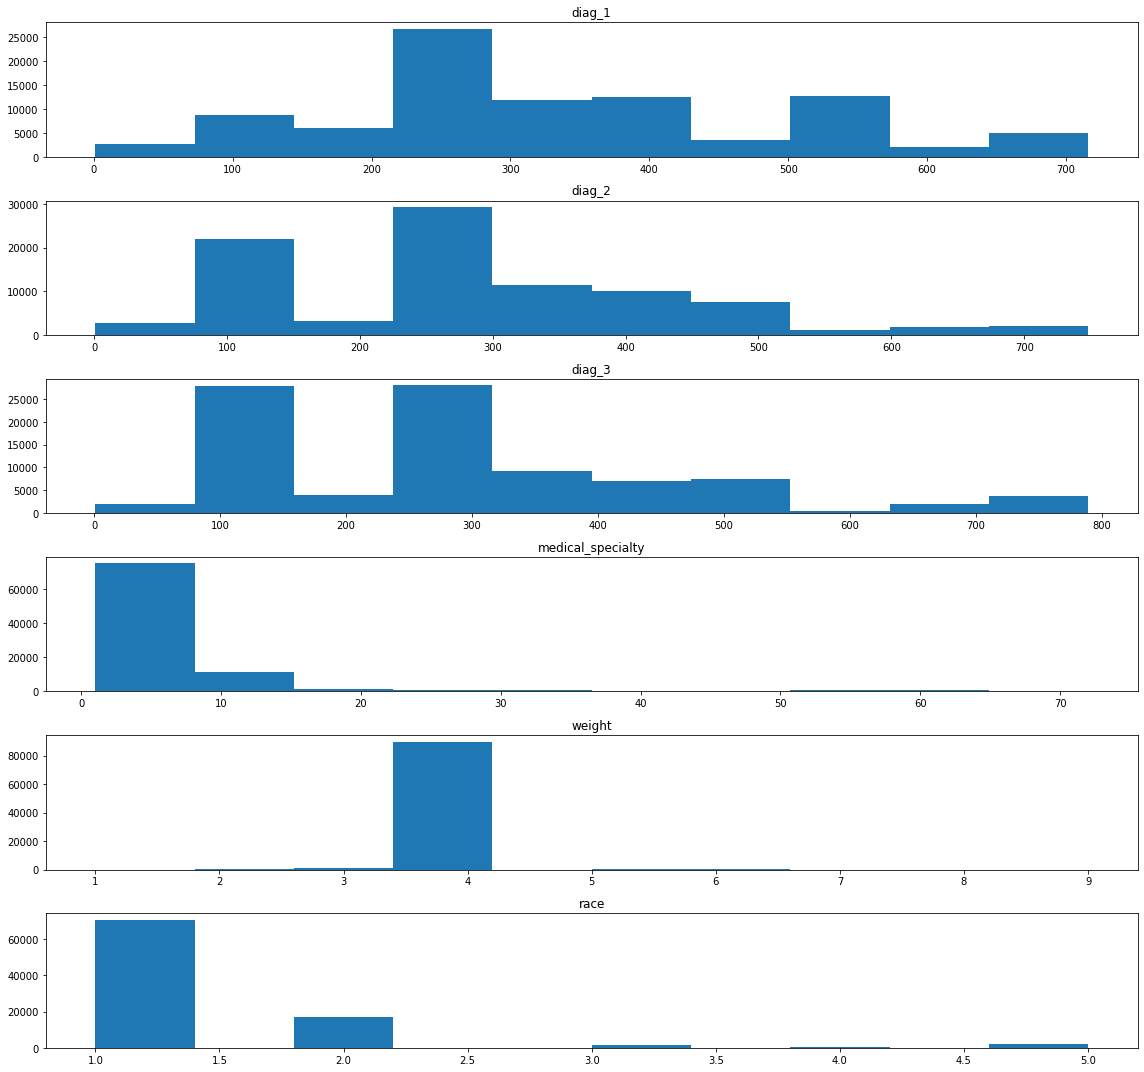

In [32]:
### Missing values have been filled. Let's take a look at the distribution
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(missing_cols), figsize = (16,15), tight_layout = True)
k = 0
for i in range(len(missing_cols)):
    axes[i].hist(X_train[missing_cols[k]])
    axes[i].title.set_text(missing_cols[k])
    k += 1

### Outlier Detection.

The algorithm goes as follows:

For every column in X_train:
   1. Compute the mean and standard deviation for that column
   
   2. For every observation, if the obsersataion > mean + 3 * |s| then replace with the mean
   
   3. Perform step 2 on the testing data as well using the mean and sd from the mean (to avoid data leakage)

It is important to note that a lot of the original data was categorical and numerical.

Here, I will use my intuition and apply this outlier detection method on data that I deemed non-cateogorical.

The reason I do not want to remove outliers in the categorical data is because some of those cateogircal outliers could end up being useful in prediction.


In general, the criteria that I used to determine which data was numerical vs categorical:

I classified numerical data columns as follows:

1. Was the dataset labled as numerical in the original diabetic_data.csv?
2. If so, then observe the column name and the values to determine if they are deemed originally numerical


The equation for outlier detection is located at:

Machine Learning-Based Classification Algorithms for the Prediction of Coronary Heart Diseases, Kelvin Kwakye & Emmanuel Dadzie, 2021, page 3 figure 3 equation 2

In [33]:
df = pd.read_csv("diabetic_data.csv")
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

### Data columns that were originally numerical to being with:

num_lab_procedures         

num_procedures             

num_medications             

number_outpatient        

number_emergency          

number_inpatient         

number_diagnoses        

time_in_hospital



Columns that were originally numerical but I did not include:

admission_type_id            

discharge_disposition_id    

admission_source_id        

Reason for not including them: I did not include them because they were more leaned towards the categorical side.

In [5]:
def outlier_counts(X_train, X_test, names):
    for col_name in names:
        print(col_name)
        counter = 0
        mean = X_train[col_name].mean()
        sd = X_train[col_name].std()
        for i in range(len(X_train)):
            if X_train.loc[i, col_name] > mean + 3 * abs(sd):
                X_train.loc[i, col_name] = mean
                counter += 1
        for i in range(len(X_test)):
            if X_train.loc[i, col_name] > mean + 3 * abs(sd):
                X_train.loc[i, col_name] = mean
                counter += 1
        print("Outerliers Replaced: ", counter)

In [6]:
names = ['num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses','time_in_hospital']
outlier_counts(X_train, X_test, names)

num_lab_procedures
Outerliers Replaced:  7
num_procedures
Outerliers Replaced:  0
num_medications
Outerliers Replaced:  545
number_outpatient
Outerliers Replaced:  2821
number_emergency
Outerliers Replaced:  2483
number_inpatient
Outerliers Replaced:  1478
number_diagnoses
Outerliers Replaced:  0
time_in_hospital
Outerliers Replaced:  1098


### General overview of this module:

1. For missing values, replace NA values with mean if they are numerical or with the mode if they were categorical

2. Perform outlier detection on data that was originally numerical using the criteria listed above

Next, we have to perform some resampling techniques because we have huge data imbalances - especially in the class 1.

On page 5 of the paper, the author mentions "The results for the original dataset revealed extremely low mean accuracy, particularly in the SVM model. As a result, the data was transformed using the Synthetic Minority
Oversampling Technique (SMOTE), which increased the
number of cases in the dataset in a balanced manner. That is, it
created new instances from existing minority cases."

Source:


Machine Learning-Based Classification Algorithms for the Prediction of Coronary Heart Diseases, Kelvin Kwakye & Emmanuel Dadzie, 2021, page 5

Here, it seems that the labels are distributed pretty well. But we will try SMOTE resampling to see if it betters our model

In [36]:
X_train.to_csv("X_train", sep=',', encoding='utf-8', index = False)
X_test.to_csv("X_test", sep=',', encoding='utf-8', index = False)
t_train.to_csv("t_train", sep=',', encoding='utf-8', index = False)
t_test.to_csv("t_test", sep=',', encoding='utf-8', index = False)